# Plaka Tanıma - UFPR-ALPR Veri Seti için OCR

Bu notebook, YOLOv8 ile tespit edilen plakalar üzerinde OCR işlemini gerçekleştirir ve UFPR-ALPR veri seti için optimize edilmiştir.

## 1. Kurulum ve İçe Aktarmalar

In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import pytesseract
from pathlib import Path

In [2]:
# src dizinini yola ekle
sys.path.append(os.path.abspath('../src'))

In [3]:
# Özel modülleri içe aktar
from plate_detection import PlateDetector
from ocr import PlateOCR
from preprocessing import preprocess_image_for_plate_detection, preprocess_plate_for_ocr

## 2. OCR Modülünü Başlatma

In [4]:
# Tesseract yolu - Windows üzerindeki kurulum yolunuzla güncelleyin
# Linux/macOS'ta bunu ayarlamanız gerekmeyebilir
tesseract_path = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # Sisteminiz için bunu güncelleyin

In [5]:
# Eğitilmiş model yolu
custom_model_path = '../models/yolov8_license_plate.pt'  # UFPR-ALPR üzerinde eğitilmiş model

In [6]:
# Özel model mevcut değilse önceden eğitilmiş modeli kullan
if not os.path.exists(custom_model_path):
    print("Özel model bulunamadı, varsayılan model kullanılıyor.")
    print("Not: Varsayılan model plaka tespitinde düşük performans gösterebilir.")
    print("Daha iyi sonuçlar için önce 'plate_detection_training.ipynb' ile bir model eğitin.")
    plate_detector_model = None  # PlateDetector varsayılan önceden eğitilmiş modeli kullanacak
else:
    print(f"Eğitilmiş model kullanılıyor: {custom_model_path}")
    plate_detector_model = custom_model_path

Eğitilmiş model kullanılıyor: ../models/yolov8_license_plate.pt


In [7]:
# Detektör ve OCR'ı başlat
detector = PlateDetector(model_path=plate_detector_model)
ocr = PlateOCR(tesseract_path=tesseract_path)

## 3. Görüntü İşleme Fonksiyonu

In [8]:
def process_image(image_path, display=True, save_results=True):
    """
    Bir görüntüyü işle, plakaları tespit et ve plaka içeriğini tanı
    
    Parametreler:
        image_path: İşlenecek görüntünün yolu
        display: Sonuçları gösterip göstermeme
        save_results: Sonuçları kayıt edip etmeme
        
    Dönüş:
        processed_results: İşlenen plaka bilgilerini içeren sözlük listesi
    """
    processed_results = []
    
    # Görüntüyü oku
    image = cv2.imread(image_path)
    if image is None:
        print(f"Hata: {image_path} yüklenemedi")
        return processed_results
    
    # Görüntüyü ön işle
    preprocessed_image = preprocess_image_for_plate_detection(image)


    # Eğer görüntü tek kanallıysa, BGR'ye çevir
    if preprocessed_image.ndim == 2 or (preprocessed_image.ndim == 3 and preprocessed_image.shape[2] == 1):
        preprocessed_image = cv2.cvtColor(preprocessed_image, cv2.COLOR_GRAY2BGR)
    
    # Plakaları tespit et
    detected_plates, annotated_image = detector.detect(preprocessed_image)
    
    if not detected_plates:
        print(f"Görüntüde plaka tespit edilemedi: {image_path}")
        return processed_results
    
    print(f"{len(detected_plates)} plaka tespit edildi")
    
    # Plaka bölgelerini çıkar
    plate_images = detector.extract_plate_regions(image, detected_plates)
    processed_plates = []
    recognized_texts = []
    
    # Her bir tespit edilen plakayı işle
    for i, plate_img in enumerate(plate_images):
        # Plakayı OCR için ön işle
        processed_plate = preprocess_plate_for_ocr(plate_img)
        
        # Plaka karakterlerini tanı
        plate_text, confidence = ocr.recognize_plate(processed_plate)
        
        # OCR sonuçlarını analiz et
        final_text, is_valid = ocr.analyze_results(plate_text, plate_text)
        
        # Plaka konumunu al
        x1, y1, x2, y2, det_conf = detected_plates[i]
        
        # İşaretlenmiş görüntüye metni ekle
        cv2.putText(annotated_image, final_text, (int(x1), int(y1) - 10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
        
        # Sonucu yazdır
        print(f"Plaka {i+1}: {final_text} (OCR Güveni: {confidence:.2f}, Tespit Güveni: {det_conf:.2f})")
        
        # Sonucu kaydet
        result = {
            'plate_text': final_text,
            'ocr_confidence': float(confidence),
            'detection_confidence': float(det_conf),
            'position': [int(x1), int(y1), int(x2), int(y2)],
            'is_valid': is_valid
        }
        processed_results.append(result)
        processed_plates.append(processed_plate)
        recognized_texts.append(final_text)
        
        # Her bir plaka görüntüsünü kaydet
        if save_results:
            os.makedirs('../results/plates', exist_ok=True)
            
            # Orijinal plakayı kaydet
            original_plate_path = f'../results/plates/original_plate_{i}_{Path(image_path).stem}.jpg'
            cv2.imwrite(original_plate_path, plate_img)
            
            # İşlenmiş plakayı kaydet
            proc_plate_path = f'../results/plates/processed_plate_{i}_{Path(image_path).stem}.jpg'
            cv2.imwrite(proc_plate_path, processed_plate)
    
    # İşaretlenmiş görüntüyü kaydet
    if save_results:
        os.makedirs('../results/images', exist_ok=True)
        result_image_path = f'../results/images/result_{Path(image_path).stem}.jpg'
        cv2.imwrite(result_image_path, annotated_image)
    
    # Sonuçları JSON olarak kaydet
    if save_results:
        os.makedirs('../results/json', exist_ok=True)
        json_path = f'../results/json/result_{Path(image_path).stem}.json'
        with open(json_path, 'w') as f:
            json.dump(processed_results, f, indent=4)
    
    # Sonuçları göster
    if display:
        plt.figure(figsize=(15, 10))
        
        # Ana görüntü ve işaretlemeler
        plt.subplot(2, 1, 1)
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        plt.title("Tespit Edilen Plakalar")
        plt.axis('off')
        
        # Plaka görüntüleri
        if len(plate_images) > 0:
            # Izgara boyutunu hesapla
            num_plates = len(plate_images)
            if num_plates <= 3:
                grid_cols = num_plates
                grid_rows = 1
            else:
                grid_cols = 3
                grid_rows = (num_plates + 2) // 3  # Yukarı yuvarla
            
            plt.figure(figsize=(15, 5 * grid_rows))
            
            for i, (plate_img, processed, text) in enumerate(zip(plate_images, processed_plates, recognized_texts)):
                plt.subplot(grid_rows, grid_cols * 2, i * 2 + 1)
                plt.imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
                plt.title(f"Orijinal Plaka {i+1}")
                plt.axis('off')
                
                # İşlenmiş plakayı al
                plt.subplot(grid_rows, grid_cols * 2, i * 2 + 2)
                plt.imshow(processed, cmap='gray')
                plt.title(f"İşlenmiş Plaka {i+1}: {text}")
                plt.axis('off')
            
            plt.tight_layout()
            plt.show()
    
    return processed_results

## 4. UFPR-ALPR Test Görüntülerini İşleme

In [9]:
def process_ufpr_test_images(test_dir='../data/raw/ufpr-alpr/testing', num_samples=5, output_dir='../results'):
    """
    UFPR-ALPR test görüntülerini işle
    
    Parametreler:
        test_dir: UFPR-ALPR test görüntülerinin bulunduğu dizin
        num_samples: İşlenecek örnek sayısı
        output_dir: Sonuçların kaydedileceği dizin
    """
    # Çıktı dizinlerini oluştur
    os.makedirs(output_dir, exist_ok=True)
    
    # Test dizini var mı kontrol et
    if not os.path.exists(test_dir):
        print(f"Hata: Test dizini bulunamadı: {test_dir}")
        return
    
    # Tüm izleme (track) klasörlerini bul
    track_dirs = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d)) and d.startswith('track')]
    
    if not track_dirs:
        print(f"Hata: {test_dir} içinde izleme klasörleri bulunamadı")
        return
    
    print(f"{len(track_dirs)} izleme klasörü bulundu")
    
    # İşlenecek görüntüleri seç
    selected_images = []
    count = 0
    
    # Her izleme klasöründen bir görüntü seç
    for track_dir in track_dirs:
        if count >= num_samples:
            break
            
        track_path = os.path.join(test_dir, track_dir)
        png_files = [f for f in os.listdir(track_path) if f.endswith('.png')]
        
        if png_files:
            # Her izlemeden ilk görüntüyü seç
            selected_images.append(os.path.join(track_path, png_files[0]))
            count += 1
    
    print(f"{len(selected_images)} test görüntüsü seçildi")
    
    all_results = {}
    
    # Her bir görüntüyü işle
    for img_path in selected_images:
        print(f"\nİşleniyor: {img_path}")
        results = process_image(img_path, display=True, save_results=True)
        all_results[os.path.basename(img_path)] = results
    
    # Tüm sonuçları tek bir JSON dosyasına kaydet
    all_results_path = os.path.join(output_dir, 'ufpr_test_results.json')
    with open(all_results_path, 'w') as f:
        json.dump(all_results, f, indent=4)
    
    print(f"\nTüm sonuçlar {all_results_path} dosyasına kaydedildi.")

## 5. Test İşlemleri

60 izleme klasörü bulundu
5 test görüntüsü seçildi

İşleniyor: ../data/raw/ufpr-alpr/testing\track0091\track0091[01].png



0: 416x736 1 license_plate, 757.4ms
Speed: 14.6ms preprocess, 757.4ms inference, 4.8ms postprocess per image at shape (1, 3, 416, 736)
1 plaka tespit edildi
Plaka 1: MLS5511 (OCR Güveni: 0.70, Tespit Güveni: 0.87)


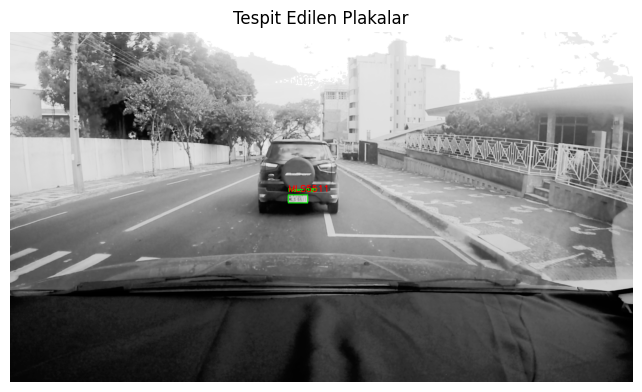

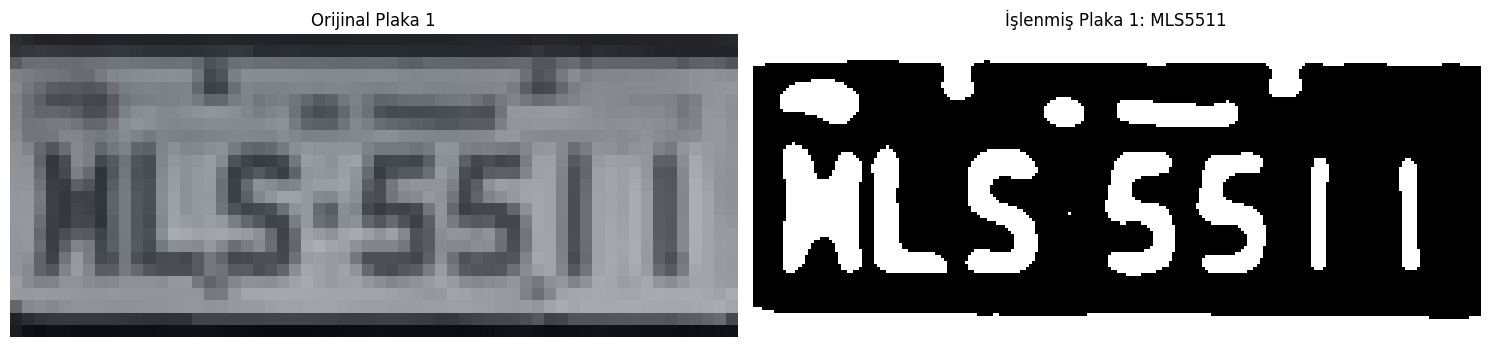


İşleniyor: ../data/raw/ufpr-alpr/testing\track0092\track0092[01].png

0: 416x736 1 license_plate, 313.7ms
Speed: 5.9ms preprocess, 313.7ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 736)
1 plaka tespit edildi
Plaka 1: V38 (OCR Güveni: 0.30, Tespit Güveni: 0.74)


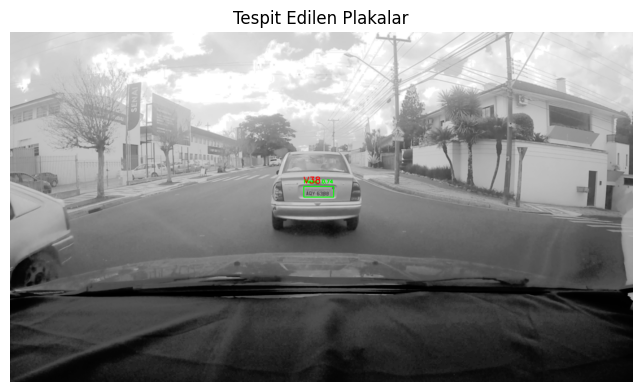

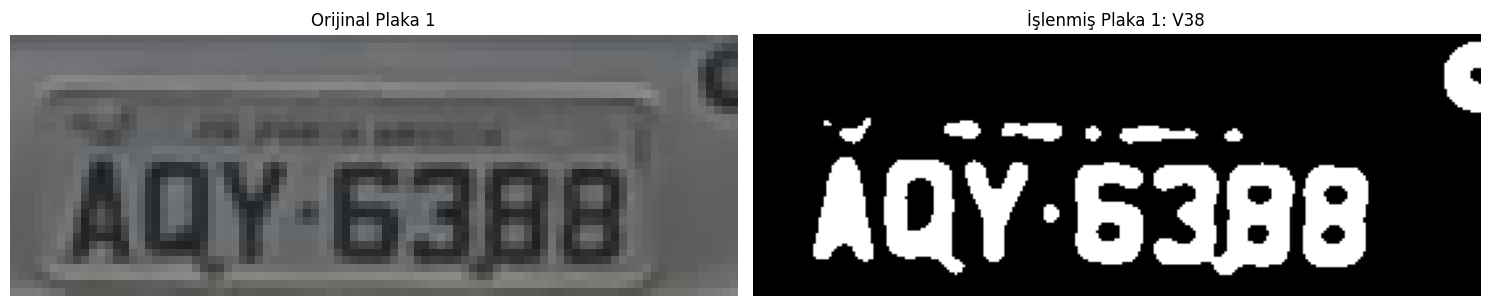


İşleniyor: ../data/raw/ufpr-alpr/testing\track0093\track0093[01].png

0: 416x736 1 license_plate, 364.1ms
Speed: 6.0ms preprocess, 364.1ms inference, 22.7ms postprocess per image at shape (1, 3, 416, 736)
1 plaka tespit edildi
Plaka 1: A226958 (OCR Güveni: 0.70, Tespit Güveni: 0.88)


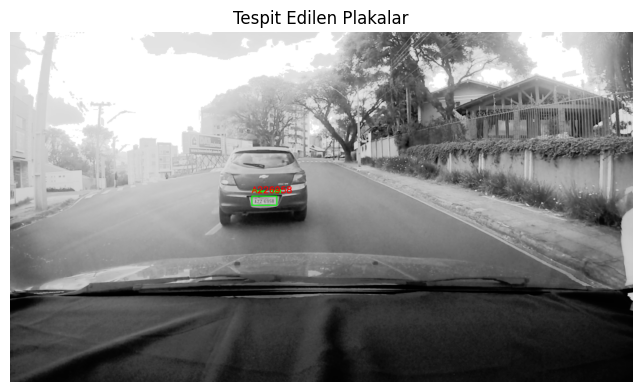

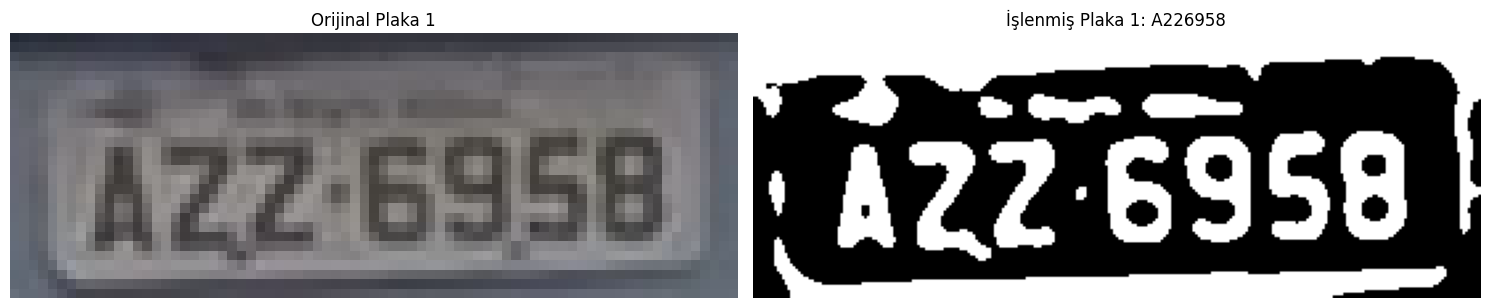


İşleniyor: ../data/raw/ufpr-alpr/testing\track0094\track0094[01].png

0: 416x736 1 license_plate, 461.3ms
Speed: 5.6ms preprocess, 461.3ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 736)
1 plaka tespit edildi
Plaka 1:  (OCR Güveni: 0.00, Tespit Güveni: 0.77)


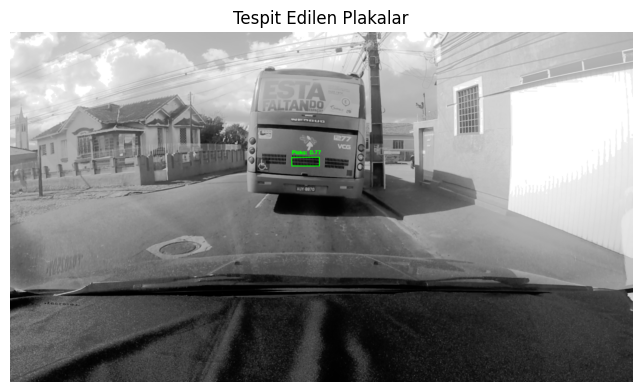

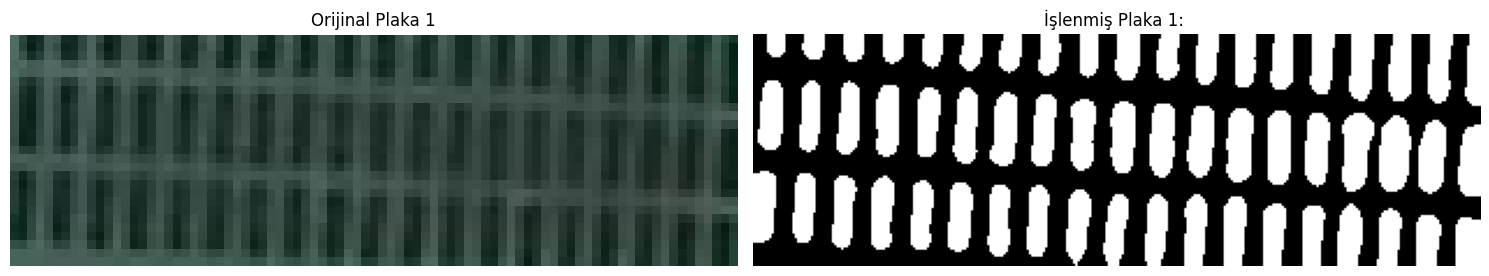


İşleniyor: ../data/raw/ufpr-alpr/testing\track0095\track0095[01].png

0: 416x736 1 license_plate, 414.8ms
Speed: 27.5ms preprocess, 414.8ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 736)
1 plaka tespit edildi
Plaka 1: IRYT2214 (OCR Güveni: 0.80, Tespit Güveni: 0.42)


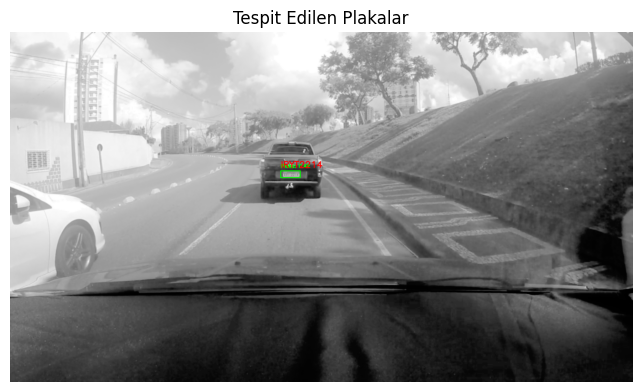

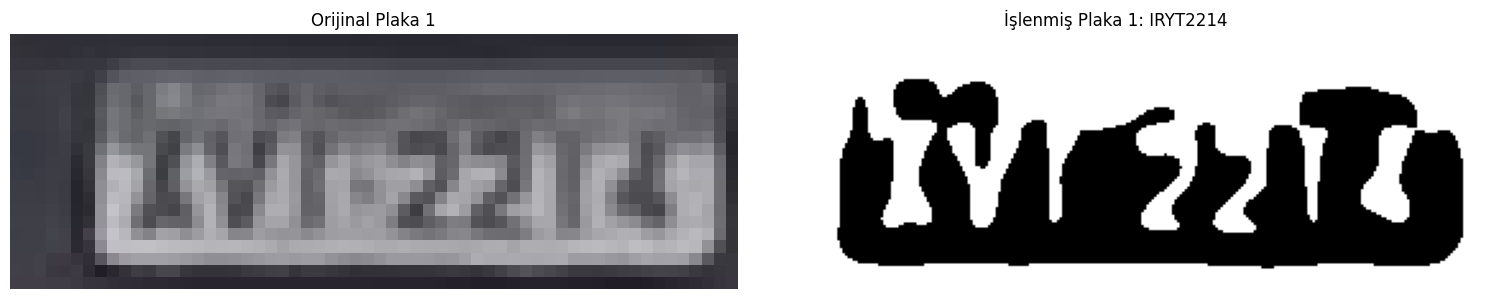


Tüm sonuçlar ../results\ufpr_test_results.json dosyasına kaydedildi.


In [19]:
# UFPR-ALPR test görüntülerini işle (5 örnek)
process_ufpr_test_images(num_samples=5)